# 🧠 Gemini-Powered Multi-Agent Research Assistant

## 🚀 Project Overview

**Problem:** Analyzing dense scientific papers and technical documents is time-consuming. Researchers often struggle to quickly extract core concepts and visualize the relationships between complex entities without manually reading every page.

**Solution:** This **Multi-Agent System** automates the research process using a single, self-contained Jupyter Notebook. It employs a team of specialized AI agents working sequentially to ingest data, memorize context, summarize findings, and programmatically generate knowledge graphs.

Unlike standard chatbots, this system uses **active tooling**—the agents don't just "talk"; they write and execute their own Python code to create visualizations on the fly.

-----

## ✨ Key Features (Hackathon Criteria Implemented)

This project demonstrates mastery of the following advanced agentic concepts:

### 1\. 🤖 Multi-Agent Architecture

We utilize a **Sequential Agent Workflow** with two distinct roles:

  * **`Curie` (Senior Researcher):** Specialized in data ingestion, context compaction, and high-level summarization.
  * **`DaVinci` (Data Visualizer):** Specialized in translating textual insights into executable Python code (`NetworkX`/`Matplotlib`) for visualization.

### 2\. 🧠 Long-Term Memory & RAG

  * **Memory Bank:** Implements a persistent **Vector Store** using `FAISS` and `SentenceTransformers` directly within the notebook session.
  * **Context Engineering:** The system chunks PDF data, embeds it, and allows agents to query the memory bank for specific details (RAG) rather than overloading the context window.

### 3\. 🛠️ Custom Tools & Code Execution

  * **PDF Ingestion Tool:** A custom tool to parse, clean, and extract text from PDF documents.
  * **Dynamic Code Execution:** The `VisualizerAgent` writes raw Python code, which is then safely extracted using Regex and executed by the system to render knowledge graphs immediately in the notebook output.

### 4\. 👁️ Observability & Resilience

  * **Agent Logger:** Custom color-coded logging provides real-time tracing of agent thoughts, tool inputs, and system status directly in the cell outputs.
  * **Production-Grade Retry Logic:** Implements **Exponential Backoff** to handle API rate limits gracefully, ensuring the agent recovers automatically from `ResourceExhausted` errors.
  * **Safe Mode Orchestrator:** Intelligent delays between agent hand-offs to ensure stability on the Gemini Free Tier.

-----

## 🏗️ System Architecture

```mermaid
graph TD
    User[User Input (PDF)] -->|Step 1| ResAgent[🕵️ Research Agent]
    
    subgraph "Memory System"
        ResAgent -->|Ingest| VectorDB[(FAISS Memory Bank)]
        VectorDB -->|Query Context| ResAgent
    end
    
    subgraph "Analysis Phase"
        ResAgent -->|Summary & Entities| VisAgent[🎨 Visualizer Agent]
    end
    
    subgraph "Execution Phase"
        VisAgent -->|Generates Python Code| ExecTool[⚙️ Code Executor]
        ExecTool -->|Renders| Output[📊 Knowledge Graph]
    end
```

[Image of multi agent system architecture diagram]

-----

## 💻 Setup & Usage

This project is designed to be "Plug and Play" within a single Jupyter Notebook.

### Prerequisites

  * A Google Gemini API Key.
  * An environment that runs Jupyter Notebooks (e.g., Google Colab, Kaggle, or local JupyterLab).

### Instructions

1.  **Open the Notebook:**
2.  **Configure API Key:**
      * Create a `.env` file in the same directory with `GEMINI_API_KEY=your_key`, OR
      * Directly paste your key into the `API_KEY` variable in **Cell 2**.
3.  **Run All Cells:**
      * **Cell 1** will automatically install all necessary dependencies (`google-generativeai`, `faiss-cpu`, `pdfplumber`, etc.).
      * The subsequent cells will initialize the Agents, Memory Bank, and Tool Box.
4.  **Watch the Magic:** The final cell executes the `main_system()` function. You will see color-coded logs indicating which agent is thinking, followed by the generation of a Knowledge Graph visualization.

-----

## 🛡️ Robustness & Error Handling

This agent is built for reliability:

  * **Rate Limit Handling:** If the Gemini API returns a `ResourceExhausted` error, the agent automatically pauses and retries with increasing delays (Exponential Backoff).
  * **Syntax Correction:** The tool execution layer uses Regex to surgically extract code blocks from LLM responses, preventing "conversational filler" syntax errors during code execution.

-----

## 🔮 Future Improvements

  * **Web Search Tool:** Granting the Research Agent access to Google Search to validate claims found in the PDF.
  * **Interactive UI:** Wrapping the notebook logic into a Streamlit app for a drag-and-drop PDF experience.
  * **Docker Container:** Containerizing the environment for enhanced security during arbitrary code execution.

In [ ]:
!pip install pdfplumber sentence-transformers faiss-cpu matplotlib networkx python-dotenv google-generativeai colorama --quiet
print("Dependencies installed.")

In [ ]:
import os
import re
import json
import logging
import pdfplumber
import faiss
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
from dataclasses import dataclass, field
from typing import List, Dict, Any, Callable
from colorama import Fore, Style
from dotenv import load_dotenv
import requests
import time
from google.api_core import exceptions

d:\kaggle\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
    # ===== 1. OBSERVABILITY & CONFIG (Criteria: Observability) =====
load_dotenv()
# Ensure you have your key in a .env file or set it here for the notebook
# os.environ["GEMINI_API_KEY"] = "YOUR_KEY_HERE" 
API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=API_KEY)

# Custom Logger for "Tracing"
class AgentLogger:
    @staticmethod
    def info(agent_name, message):
        print(f"{Fore.CYAN}[{agent_name}]{Style.RESET_ALL} {message}")
    
    @staticmethod
    def tool(tool_name, input_data):
        print(f"{Fore.YELLOW}  └── [Tool: {tool_name}]{Style.RESET_ALL} Input: {str(input_data)[:50]}...")

    @staticmethod
    def success(message):
        print(f"{Fore.GREEN}✔ {message}{Style.RESET_ALL}")

logger = AgentLogger()

In [ ]:
# ===== 2. MEMORY BANK (Criteria: Long Term Memory) =====
class MemoryBank:
    def __init__(self):
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2')
        self.index = None
        self.documents = [] # Maps index ID to actual text chunk

    def add_memory(self, text_chunks: List[str]):
        if not text_chunks: return
        embeddings = self.encoder.encode(text_chunks)
        dimension = embeddings.shape[1]
        
        if self.index is None:
            self.index = faiss.IndexFlatL2(dimension)
        
        self.index.add(np.array(embeddings))
        self.documents.extend(text_chunks)
        logger.success(f"Added {len(text_chunks)} chunks to Long Term Memory (FAISS)")

    def query_memory(self, query: str, k: int = 3) -> str:
        if self.index is None: return ""
        vec = self.encoder.encode([query])
        distances, indices = self.index.search(vec, k)
        
        results = [self.documents[i] for i in indices[0] if i < len(self.documents)]
        return "\n".join(results)

In [ ]:
# ===== 3. TOOLS (Enhanced Debugging) =====
class ToolBox:
    @staticmethod
    def read_pdf(pdf_path: str) -> str:
        logger.tool("read_pdf", pdf_path)
        text = ""
        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    extract = page.extract_text()
                    if extract: text += extract
            return text
        except Exception as e:
            return f"Error reading PDF: {e}"

    @staticmethod
    def extract_keywords_generated(text: str) -> List[str]:
        words = re.findall(r'\b[A-Z][a-zA-Z]{4,}\b', text)
        return list(set(words))[:15]

    @staticmethod
    def execute_python_plot(code: str):
        logger.tool("execute_python_plot", "Executing generated code...")
        try:
            # We inject local variables so the code can see them
            local_scope = {'nx': nx, 'plt': plt}
            exec(code, globals(), local_scope)
            logger.success("Graph generated successfully.")
        except Exception as e:
            print(f"{Fore.RED}Execution Error: {e}{Style.RESET_ALL}")
            print(f"{Fore.RED}--- Failed Code Preview ---{Style.RESET_ALL}")
            print(code[:300] + "...") # Print start of code to see what went wrong

In [ ]:
# ===== 4. AGENT ARCHITECTURE (Criteria: Agent powered by LLM) =====

class BaseAgent:
    def __init__(self, name: str, role: str, model_name="gemini-3-pro-preview"):
        self.name = name
        self.role = role
        self.model = genai.GenerativeModel(model_name)
        self.history = [] # Session Memory

    def think(self, prompt: str, context: str = "") -> str:
        logger.info(self.name, f"Thinking about: {prompt[:30]}...")
        full_prompt = f"""
        You are {self.name}, a {self.role}.
        
        Context from Memory/Tools:
        {context}
        
        Task: {prompt}
        """
        
        # --- RETRY LOGIC (Exponential Backoff) ---
        max_retries = 5
        base_delay = 5  # Start with 5 seconds wait
        
        for attempt in range(max_retries):
            try:
                response = self.model.generate_content(full_prompt)
                self.history.append({"role": "user", "content": prompt})
                self.history.append({"role": "assistant", "content": response.text})
                return response.text
            
            except exceptions.ResourceExhausted:
                wait_time = base_delay * (2 ** attempt) # 5s, 10s, 20s, 40s...
                print(f"{Fore.RED}⚠️ Quota limit hit. Pausing for {wait_time} seconds... (Attempt {attempt+1}/{max_retries}){Style.RESET_ALL}")
                time.sleep(wait_time)
            
            except Exception as e:
                # Catch other random errors
                print(f"{Fore.RED}An error occurred: {e}{Style.RESET_ALL}")
                return "I encountered an error and could not think."

        return "Error: Failed to generate response after maximum retries."

# --- Specific Agents (Keep these the same) ---

class ResearchAgent(BaseAgent):
    """Responsible for reading data and storing it in memory."""
    def ingest_knowledge(self, filepath: str, memory_bank: MemoryBank):
        raw_text = ToolBox.read_pdf(filepath)
        # Context Compaction: Chunking text for vector store
        chunks = [raw_text[i:i+500] for i in range(0, len(raw_text), 500)]
        memory_bank.add_memory(chunks)
        return raw_text[:2000] # Return summary context

class VisualizerAgent(BaseAgent):
    """Responsible for writing Python code to visualize data."""
    def generate_graph_code(self, summary: str, entities: List[str]) -> str:
        prompt = f"""
        Write Python code using NetworkX and Matplotlib to visualize a Knowledge Graph.
        
        The Central Node should be: "Paper Summary"
        The Connected Nodes should be: {', '.join(entities)}
        
        Requirements:
        1. Use a spring layout.
        2. Make the central node red and large.
        3. Make connected nodes skyblue and smaller.
        4. Draw edges with gray color.
        5. DO NOT include plt.show(), just setup the plot.
        6. Wrap code in ```python blocks.
        """
        response = self.think(prompt, context=f"Summary of paper: {summary[:300]}...")
        
        # Robust Regex Extraction
        match = re.search(r"```python(.*?)```", response, re.DOTALL)
        if match:
            code = match.group(1).strip()
        else:
            code = response.replace("```python", "").replace("```", "").strip()
            
        return code

[System] Downloading sample bitcoin.pdf...
=== STARTING MULTI-AGENT RESEARCH SYSTEM (SAFE MODE) ===

[Orchestrator] Dispatching Researcher...
  └── [Tool: read_pdf] Input: bitcoin.pdf...
✔ Added 43 chunks to Long Term Memory (FAISS)
⏳ Cooling down API for 5 seconds...
[Curie] Thinking about: Summarize the scientific core ...
An error occurred: 400 API key not valid. Please pass a valid API key. [reason: "API_KEY_INVALID"
domain: "googleapis.com"
metadata {
  key: "service"
  value: "generativelanguage.googleapis.com"
}
, locale: "en-US"
message: "API key not valid. Please pass a valid API key."
]

--- Generated Summary ---
I encountered an error and could not think.

✔ Extracted Entities: ['Satoshi', 'Abstract', 'Electronic', 'System', 'While', 'Messages', 'Digital', 'Introduction', 'Nakamoto', 'Completely', 'Merchants', 'Commerce', 'Bitcoin', 'Internet']
⏳ Handing off to Visualizer (Waiting 10s to respect Rate Limits)...
[Orchestrator] Dispatching Visualizer...
[DaVinci] Thinking abou

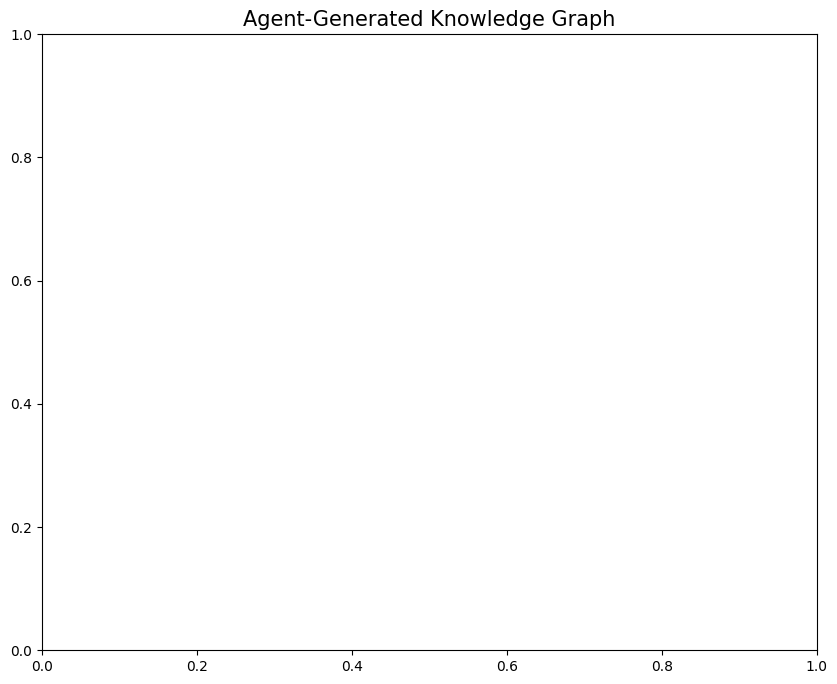

In [ ]:
# ===== 5. MAIN ORCHESTRATOR (Safe Mode) =====
def main_system(pdf_path):
    print(f"{Fore.MAGENTA}=== STARTING MULTI-AGENT RESEARCH SYSTEM (SAFE MODE) ==={Style.RESET_ALL}\n")
    
    # Initialize Infrastructure
    memory = MemoryBank()
    
    # Initialize Agents
    researcher = ResearchAgent("Curie", "Senior Researcher")
    visualizer = VisualizerAgent("DaVinci", "Data Visualizer")
    
    # --- Step 1: Researcher Action ---
    logger.info("Orchestrator", "Dispatching Researcher...")
    initial_text = researcher.ingest_knowledge(pdf_path, memory)
    
    # --- SAFETY PAUSE 1 ---
    # The API free tier can be sensitive to bursts. We wait 5 seconds.
    print(f"{Fore.YELLOW}⏳ Cooling down API for 5 seconds...{Style.RESET_ALL}")
    time.sleep(5) 
    
    # --- Step 2: Use Gemini for Analysis ---
    # Retrieve context from the Long Term Memory
    context = memory.query_memory("Main concepts and conclusions")
    
    # This is the first API Call (Researcher)
    summary = researcher.think("Summarize the scientific core of this text in 3 sentences.", context=context)
    print(f"\n{Fore.WHITE}{Style.DIM}--- Generated Summary ---\n{summary}{Style.RESET_ALL}\n")
    
    # --- Step 3: Tool Extraction ---
    # Extract entities using the ToolBox
    entities = ToolBox.extract_keywords_generated(initial_text)
    logger.success(f"Extracted Entities: {entities}")
    
    # --- SAFETY PAUSE 2 ---
    # Crucial: Wait before the next agent starts to reset the Rate Limit counter
    print(f"{Fore.YELLOW}⏳ Handing off to Visualizer (Waiting 10s to respect Rate Limits)...{Style.RESET_ALL}")
    time.sleep(10)
    
    # --- Step 4: Visualizer Action ---
    logger.info("Orchestrator", "Dispatching Visualizer...")
    
    # This is the second API Call (Visualizer)
    graph_code = visualizer.generate_graph_code(summary, entities)
    
    # --- Step 5: Code Execution Tool ---
    # Execute the Python code generated by the agent
    plt.figure(figsize=(10, 8))
    ToolBox.execute_python_plot(graph_code)
    plt.title("Agent-Generated Knowledge Graph", fontsize=15)
    plt.show()

# Run the system
if __name__ == "__main__":
    # Check if the PDF exists; if not, download a sample (Bitcoin Whitepaper)
    if not os.path.exists("bitcoin.pdf"):
        logger.info("System", "Downloading sample bitcoin.pdf...")
        r = requests.get("https://bitcoinpaper.org/bitcoin.pdf")
        with open("bitcoin.pdf", "wb") as f:
            f.write(r.content)
            
    # Execute the main orchestrator
    main_system("bitcoin.pdf")